In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection-dataset/data2.csv


In [134]:
import pandas as pd
data = pd.read_csv('/kaggle/input/fraud-detection-dataset/data2.csv')

In [135]:
data.head()

,Profession,Income,Credit_card_number,Expiry,Security_code,Fraud
0,DOCTOR,42509,3515418493460774,07/25,251,1
1,DOCTOR,80334,213134223583196,05/32,858,1
2,LAWYER,91552,4869615013764888,03/30,755,1
3,LAWYER,43623,341063356109385,01/29,160,1
4,DOCTOR,22962,4707418777543978402,11/30,102,0


EDA

In [136]:
data.nunique()

Profession                3
Income                 9499
Credit_card_number    10000
Expiry                  121
Security_code          1699
Fraud                     2
dtype: int64

In [137]:
data.dtypes

Profession            object
Income                 int64
Credit_card_number     int64
Expiry                object
Security_code          int64
Fraud                  int64
dtype: object

In [138]:
from datetime import datetime


# Convert string to date
data['Expiry'] = pd.to_datetime(data['Expiry'], errors = 'coerce')

<ipython-input-138-46203e2fb690>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Expiry'] = pd.to_datetime(data['Expiry'], errors = 'coerce')


In [139]:
data['Fraud'] = data['Fraud'].astype(str)

In [140]:
data.dtypes

Profession                    object
Income                         int64
Credit_card_number             int64
Expiry                datetime64[ns]
Security_code                  int64
Fraud                         object
dtype: object

In [141]:
'''Only Expiry date column has missing data. Can't derive much correlation to estimate it too. 
Have to use an appropriate classification algorithm like XGBoost that can handle it'''
data.isna().sum(axis=0)

Profession               0
Income                   0
Credit_card_number       0
Expiry                7201
Security_code            0
Fraud                    0
dtype: int64

In [142]:
data.shape

(10000, 6)

In [143]:
#Segragating columns as per their datatypes for univariate dist checks
int_col = []
obj_col = []
date_col = []
for col in data.columns:
    if data[col].dtypes == "int64":
        int_col.append(col)
    elif data[col].dtypes == "object":
        obj_col.append(col)
    elif data[col].dtypes == "datetime64[ns]":
        date_col.append(col)

In [144]:
# Check for infinite values and extreme outliers
def check_data_quality(data):
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    
    print("Infinite values:")
    for col in numeric_cols:
        inf_count = np.isinf(data[col]).sum()
        if inf_count > 0:
            print(f"{col}: {inf_count}")
    
    print("\nPotential errors (values beyond 3σ):")
    for col in numeric_cols:
        mean = data[col].mean()
        std = data[col].std()
        extreme = data[col][abs(data[col] - mean) > 3*std].count()
        if extreme > 0:
            print(f"{col}: {extreme} extreme values")

check_data_quality(data)

# Why? Because:
# - XGBoost might not handle infinite values well
# - Helps identify potential data errors


Infinite values:

Potential errors (values beyond 3σ):
Credit_card_number: 713 extreme values
Security_code: 369 extreme values


In [145]:
def detect_num_feature_type(data, int_col_loc, unique_threshold_ratio = 0.5, digit_count_threshold=7):
    num_feature_types = {}
    for col in int_col_loc:
        if (((data[col].nunique()/len(data) > unique_threshold_ratio and
            data[col].astype(str).str.len().mean() >= digit_count_threshold) or
            any(x in col for x in (['id', 'code', 'number', 'card', 'account'])) and 
            not any(x in col for x in (['salary', 'income', 'sale', 'discount', 'price'])))
           ):
            num_feature_types[col] = 'identifier_numeric'
        else:
            num_feature_types[col] = 'regular_numeric'
    return num_feature_types



In [146]:
def handle_outliers(data, columns, method='winsorize', threshold=3):
    for col in columns:
        if method == 'winsorize':
            lower, upper = np.percentile(data[col], [1, 99])
            data[col] = np.clip(data[col], lower, upper)
        elif method == 'remove':
            z_scores = np.abs(stats.zscore(data[col]))
            data = data[z_scores < threshold]
        elif method == 'log':
            data[col] = np.log1p(data[col] - min(0, data[col].min()) + 1)
    return data



In [147]:
feature_types = detect_num_feature_type(data,int_col)

In [148]:
data = handle_outliers(data, [key for key, values in feature_types.items() if values == "regular_numeric"])

EDA for interpretability

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


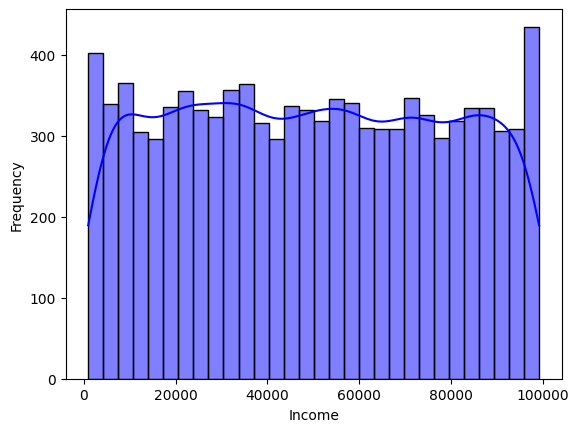

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


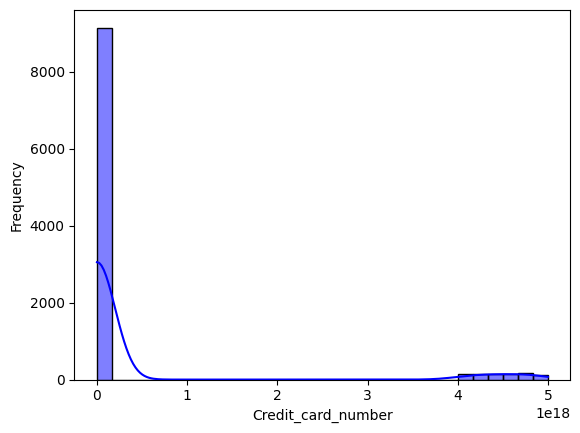

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


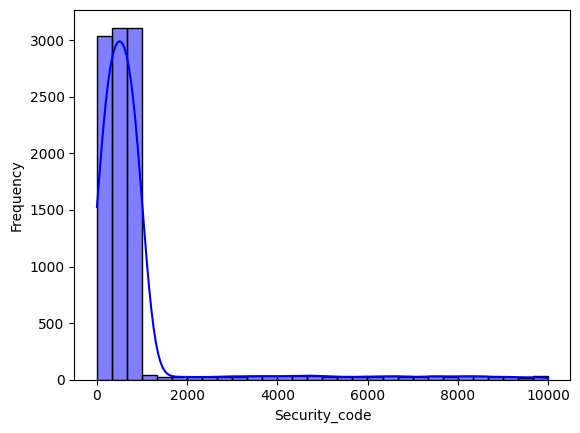

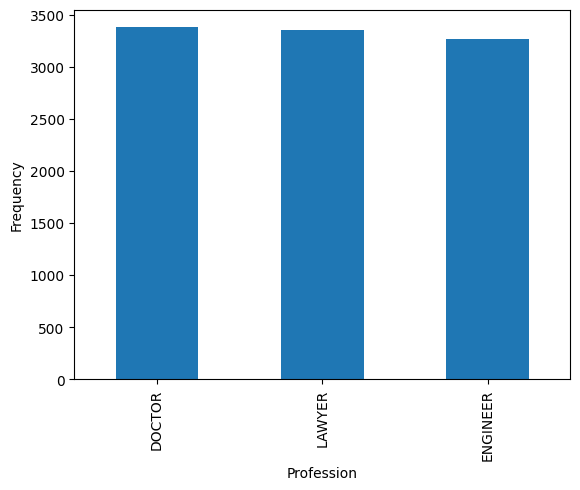

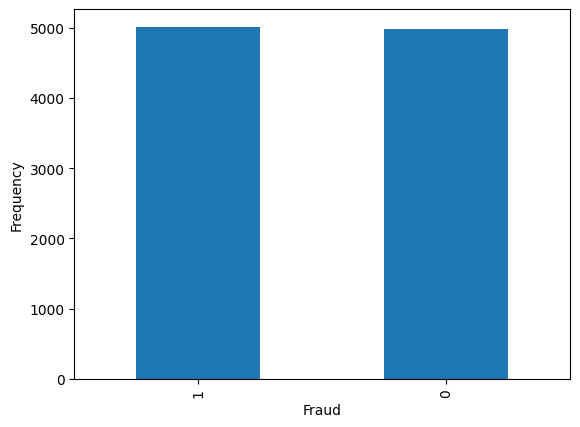

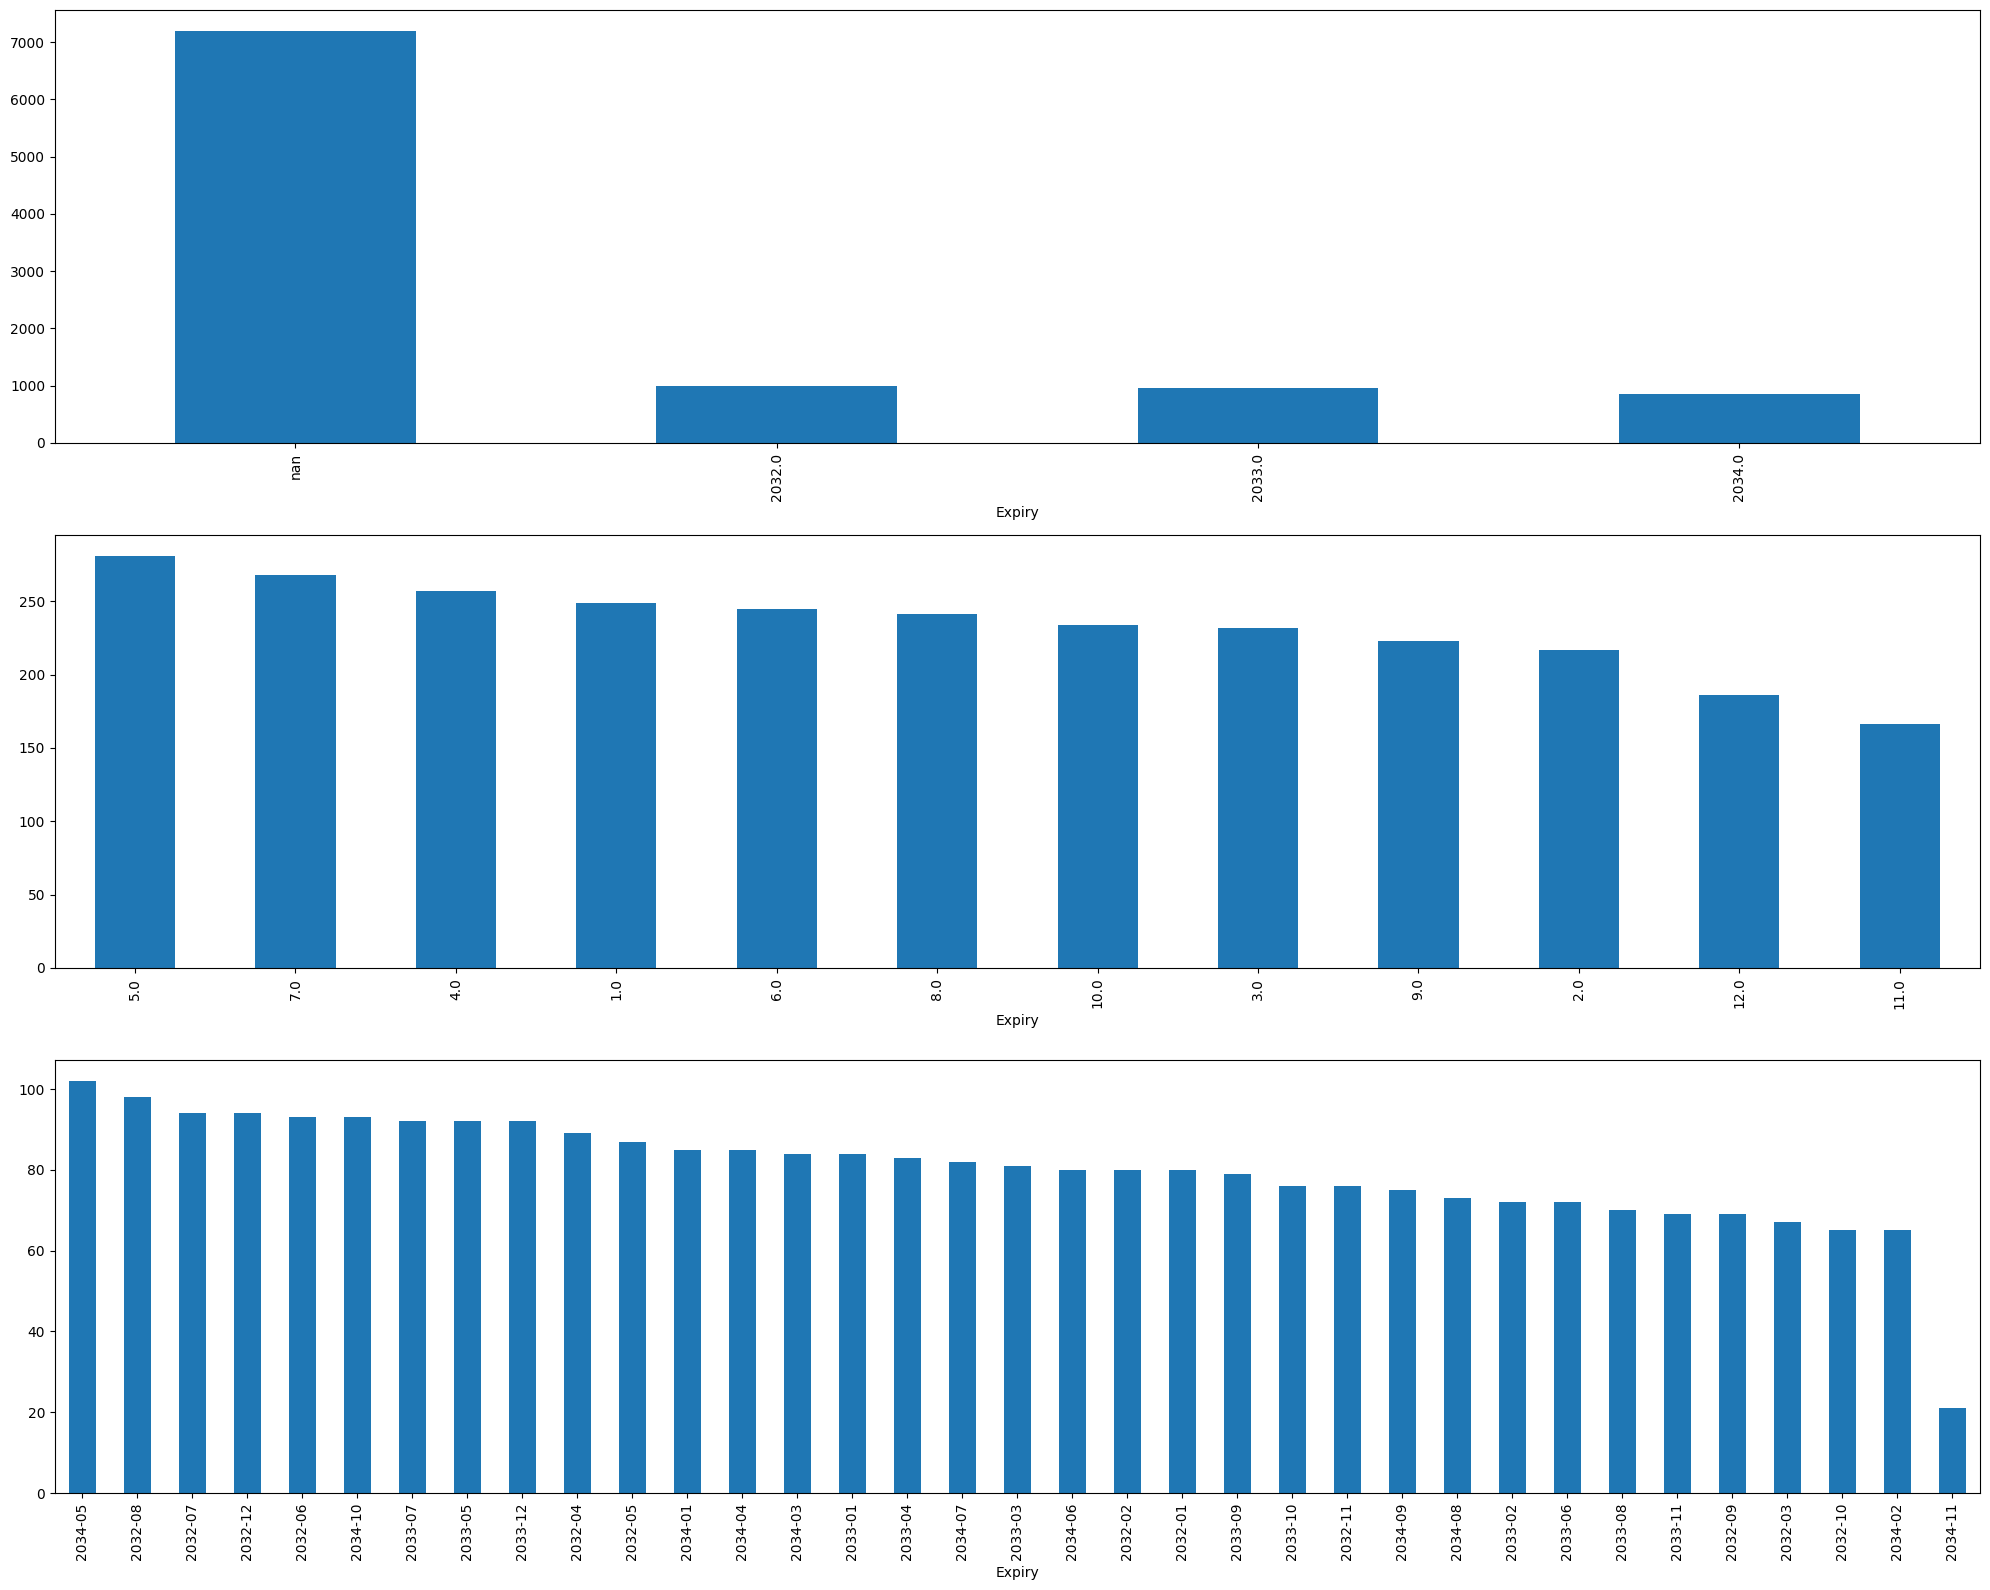

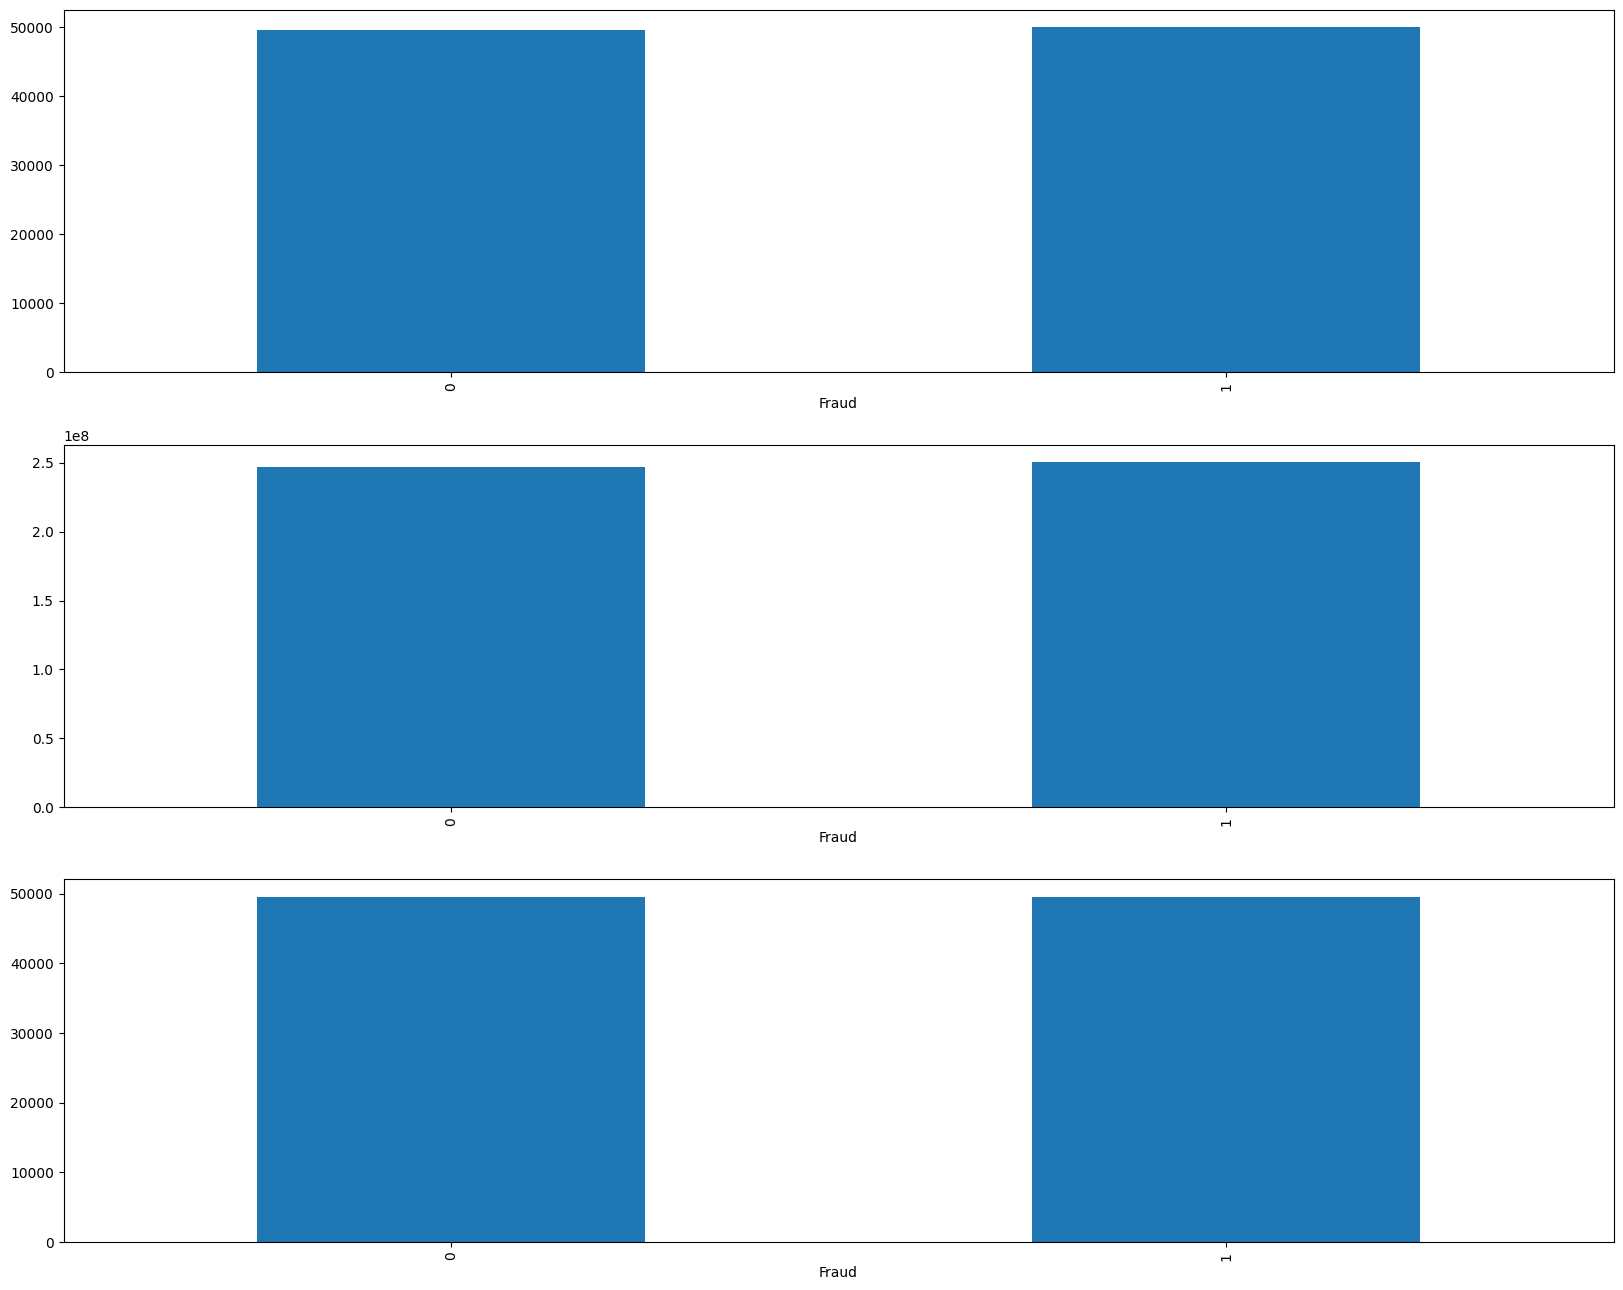

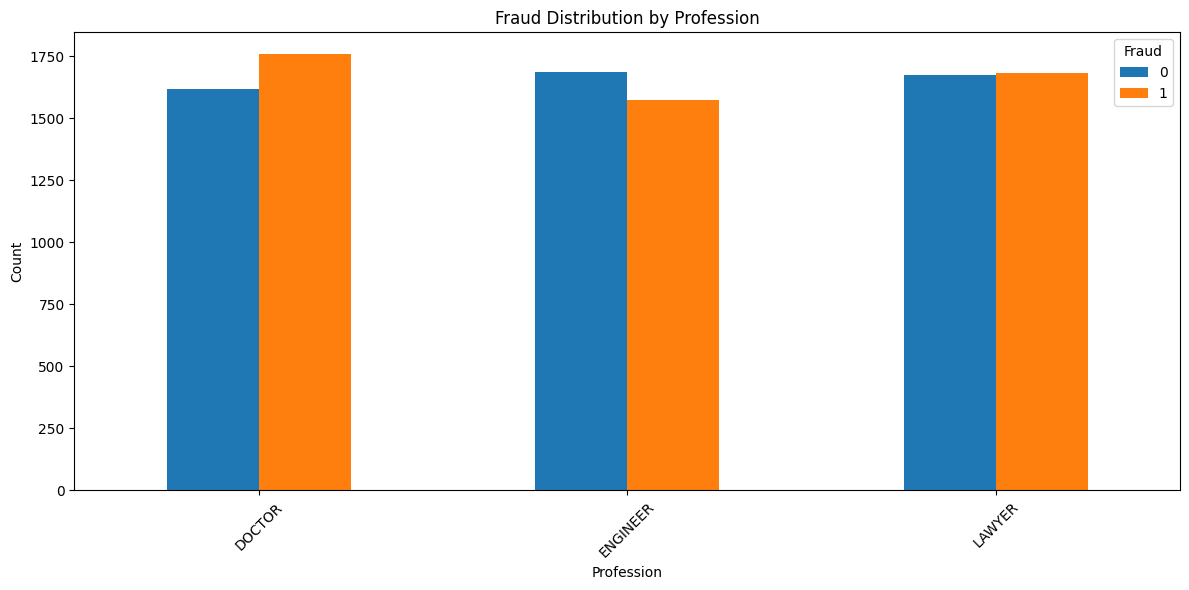

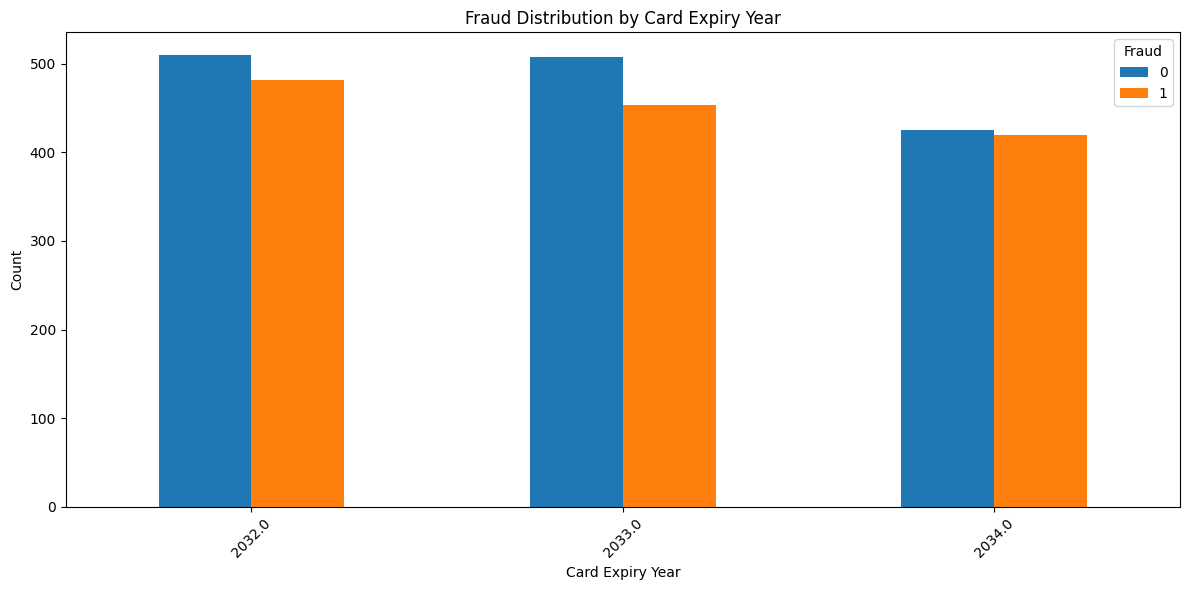

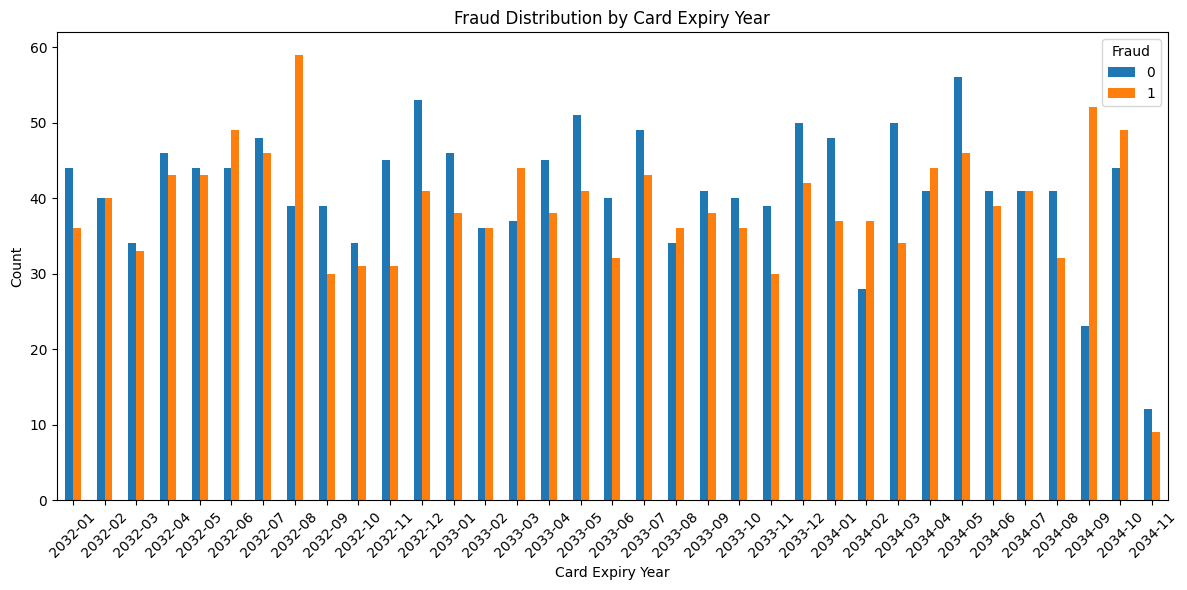

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

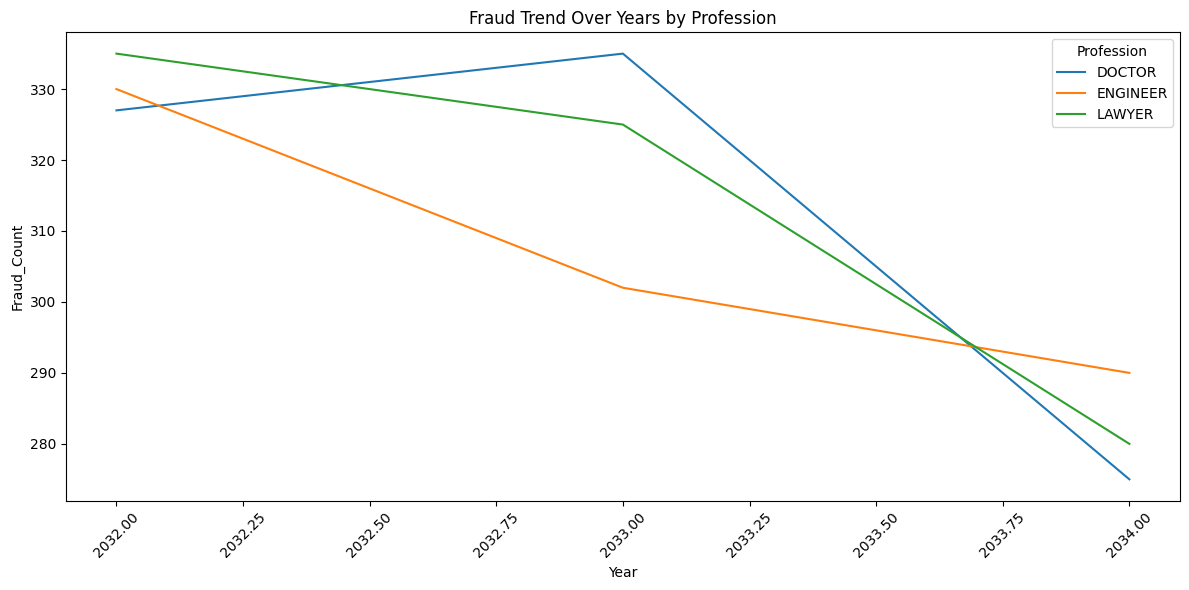

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

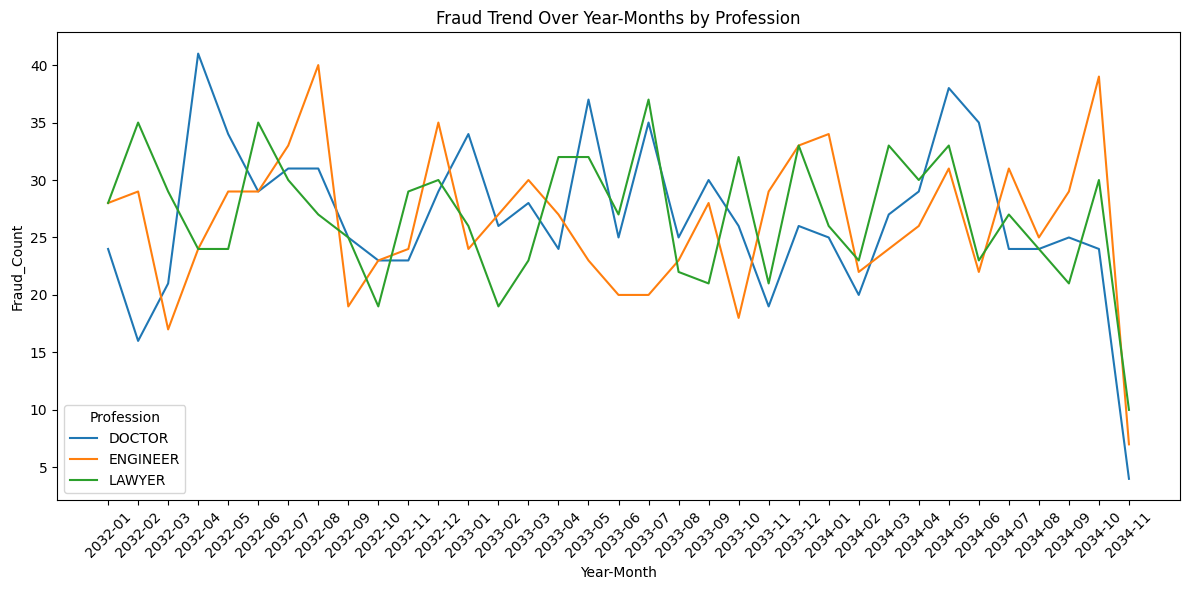

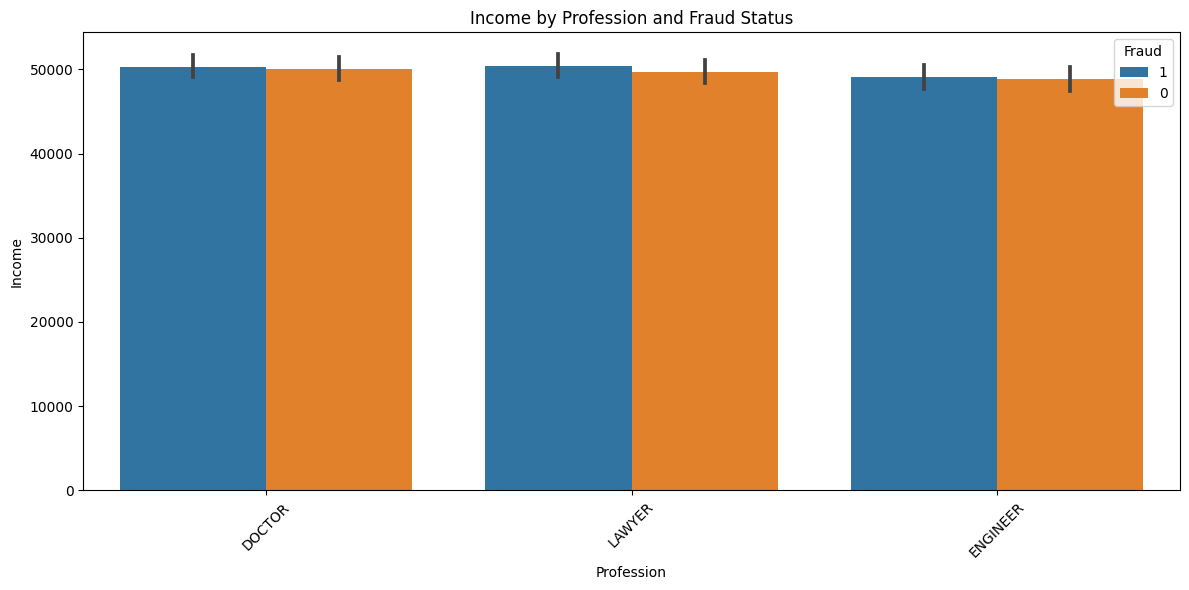

In [149]:
#Function for int datatype columns plot
import matplotlib.pyplot as plt
import seaborn as sns
def hist(column):
    sns.histplot(data[column], bins=30, kde=True, color='blue', edgecolor = 'black')
    
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

for col in int_col:
    hist(col)

'''
1.Income - Equally distributed. Does not follow normal distribution. Have to transform if using an algorithm which assumes dependent variable to follow normal dist
2.Credit card no - Holds outliers, may lead to more fraudulent payments, check in bi-variate
3.Security code - Looks like outliers but not much insight
4.Fraud - As expceted it is binary
'''

for col in obj_col:
    data[col].value_counts().sort_values(ascending = False).plot(kind='bar')
    
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

#Almost equally distributed for both

for col in date_col:
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,16))
    
    data[col].dt.year.value_counts(dropna=False).sort_values(ascending=False).plot(kind='bar', ax=axes[0])
    data[col].dt.month.value_counts().sort_values(ascending=False).plot(kind='bar', ax=axes[1])
    data[col].dt.strftime('%Y-%m').value_counts().sort_values(ascending=False).plot(kind='bar', ax=axes[2])
    
    # Add some spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()

#Lot of missing data
#Spread across 2032-34 years

# Bivariate plots (with dependent variable)

fig,axes = plt.subplots(nrows=3, ncols=1, figsize=(20,16))
data.groupby('Fraud')['Income'].mean().plot(kind = 'bar', ax=axes[0])
data.groupby('Fraud')['Income'].sum().plot(kind = 'bar', ax=axes[1])
data.groupby('Fraud')['Income'].median().plot(kind = 'bar', ax=axes[2])

data.groupby('Fraud')['Credit_card_number'].count().plot(kind = 'bar')

data.groupby('Fraud')['Security_code'].count().plot(kind = 'bar')

pd.crosstab(data['Profession'], data['Fraud']).plot(
    kind='bar',
    figsize=(12, 6)
)
plt.title('Fraud Distribution by Profession')
plt.xlabel('Profession')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


pd.crosstab(data['Expiry'].dt.year, data['Fraud']).plot(
    kind='bar',
    figsize=(12, 6)
)
plt.title('Fraud Distribution by Card Expiry Year')
plt.xlabel('Card Expiry Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


pd.crosstab(data['Expiry'].dt.strftime('%Y-%m'), data['Fraud']).plot(
    kind='bar',
    figsize=(12, 6)
)
plt.title('Fraud Distribution by Card Expiry Year')
plt.xlabel('Card Expiry Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Tri-variate plots (with dependent variable)

# Create aggregation
fraud_trend = data.groupby(['Profession', data['Expiry'].dt.year])['Fraud'].count().reset_index()
fraud_trend.columns = ['Profession', 'Year', 'Fraud_Count']

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=fraud_trend, x='Year', y='Fraud_Count', hue='Profession')
plt.title('Fraud Trend Over Years by Profession')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Create aggregation
fraud_trend = data.groupby(['Profession', data['Expiry'].dt.strftime('%Y-%m')])['Fraud'].count().reset_index()
fraud_trend.columns = ['Profession', 'Year-Month', 'Fraud_Count']

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=fraud_trend, x='Year-Month', y='Fraud_Count', hue='Profession')
plt.title('Fraud Trend Over Year-Months by Profession')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Profession', y='Income', hue='Fraud')
plt.xticks(rotation=45)
plt.title('Income by Profession and Fraud Status')
plt.tight_layout()
plt.show()


Pre-processing analysis

In [150]:
from scipy.stats import chi2_contingency,mannwhitneyu

def pre_processing_tests(data, target='Fraud'):
    """
    Tests to perform BEFORE preprocessing
    """
    # For original raw features
    # Helps understand basic relationships
    # Guides feature engineering decisions
    results = {}
    
    # Basic features
    for col in data.columns:
        if col != target:
            if data[col].dtype in ['int64', 'float64']:
                # Mann-Whitney U test
                fraud = data[data[target]=='1'][col]
                non_fraud = data[data[target]=='0'][col]
                stat, p_val = mannwhitneyu(fraud, non_fraud)
                results[col] = {'test': 'mann_whitney', 'p_value': p_val}
            
            elif data[col].dtype == 'object':
                # Chi-square test
                contingency = pd.crosstab(data[col], data[target])
                chi2, p_val, _, _ = chi2_contingency(contingency)
                results[col] = {'test': 'chi_square', 'p_value': p_val}
    
    return pd.DataFrame(results).T

pre_processing_tests(data)

,test,p_value
Profession,chi_square,0.008799
Income,mann_whitney,0.469093
Credit_card_number,mann_whitney,0.980382
Security_code,mann_whitney,0.634643


Processing

In [151]:
def identifier_numeric_derived_feat(col):
    features = pd.DataFrame()
    # Length of the number
    features[f'{col}length'] = data[col].astype(str).str.len()
    
    # First few digits (useful for BIN numbers, area codes, etc.)
    features[f'{col}first_3'] = data[col].astype(str).str[:3].astype(float)
    
    # Last few digits
    features[f'{col}last_4'] = data[col].astype(str).str[-4:].astype(float)
    
    # Statistical ranking (maintains outlier information)
    features[f'{col}rank_norm'] = data[col].rank(pct=True)
    
    # Binning into quantiles (preserves distribution information)
    features[f'{col}quantile'] = pd.qcut(data[col], q=10, labels=False, duplicates='drop')
    
    return features



In [152]:
def date_derived_feat(data,col):
    features = pd.DataFrame()
    # Length of the number
    features[f'{col}year'] = data[col].dt.year
    
    # First few digits (useful for BIN numbers, area codes, etc.)
    features[f'{col}month'] = data[col].dt.month
    
    # Last few digits
    features[f'{col}day'] = data[col].dt.day
    
    # Statistical ranking (maintains outlier information)
    features[f'{col}dayofweek'] = data[col].dt.dayofweek
    
    # Binning into quantiles (preserves distribution information)
    features[f'{col}isweekend'] = data[col].dt.dayofweek.isin([5,6]).astype(int)

    # Binning into quantiles (preserves distribution information)
    features[f'{col}unix'] = data[col].astype(int)//10**9
    
    return features

In [153]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess_mixed_data(data, numeric_features, categorical_features):
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return preprocessor

In [154]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_features(data, columns, method='standard'):
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    
    data[columns] = scaler.fit_transform(data[columns])
    return data, scaler

# Example usage
# data, scaler = scale_features(data, ['age', 'income'], method='standard')



In [155]:
for col in data.select_dtypes(['int64','float64']):
    int_col.append(col)
int_col = list(set(int_col))

In [156]:
target=['Fraud']

In [157]:
feature_types

{'Income': 'regular_numeric',
 'Credit_card_number': 'identifier_numeric',
 'Security_code': 'identifier_numeric'}

In [158]:

derived_data = data.copy()
for key,value in feature_types.items():
    if value == 'identifier_numeric':
        col_derived_data = identifier_numeric_derived_feat(key)
        derived_data = pd.concat([derived_data, col_derived_data], axis=1)

for col in date_col:
    date_derived_data = date_derived_feat(derived_data,col)
    derived_data = pd.concat([derived_data, date_derived_data], axis=1)

derived_data = handle_outliers(derived_data, [key for key, values in feature_types.items() if values == "regular_numeric"])

for col in derived_data.select_dtypes(['int64','float64']):
    int_col.append(col)
int_col = list(set(int_col))

for col in derived_data.select_dtypes(['object']):
    obj_col.append(col)
obj_col = list(set(obj_col) - set(target))

for col in derived_data.select_dtypes(['datetime64[ns]']):
    date_col.append(col)
date_col = list(set(date_col))

preprocessor = preprocess_mixed_data(derived_data, 
                                     numeric_features=int_col,
                                     categorical_features=obj_col)

transformed_data = preprocessor.fit_transform(derived_data)
# Get feature names for numeric columns (unchanged)
numeric_features_final = int_col

# Get feature names for categorical columns (with one-hot encoding)
categorical_features_final = []
if obj_col:  # Only if there are categorical features
    onehot_features = preprocessor.named_transformers_['cat'].get_feature_names_out(obj_col)
    categorical_features_final = onehot_features.tolist()

# Combine all feature names
all_features = numeric_features_final + categorical_features_final


preprocessed_data = pd.DataFrame(transformed_data, columns = all_features)

scaled_data, scaler_used = scale_features(preprocessed_data, preprocessed_data.columns)

In [159]:
print(data.columns, derived_data.columns, preprocessed_data.columns, scaled_data.columns)

Index(['Profession', 'Income', 'Credit_card_number', 'Expiry', 'Security_code',
       'Fraud'],
      dtype='object') Index(['Profession', 'Income', 'Credit_card_number', 'Expiry', 'Security_code',
       'Fraud', 'Credit_card_numberlength', 'Credit_card_numberfirst_3',
       'Credit_card_numberlast_4', 'Credit_card_numberrank_norm',
       'Credit_card_numberquantile', 'Security_codelength',
       'Security_codefirst_3', 'Security_codelast_4', 'Security_coderank_norm',
       'Security_codequantile', 'Expiryyear', 'Expirymonth', 'Expiryday',
       'Expirydayofweek', 'Expiryisweekend', 'Expiryunix'],
      dtype='object') Index(['Credit_card_numberfirst_3', 'Income', 'Expirymonth',
       'Credit_card_numberquantile', 'Expiryyear', 'Security_codelast_4',
       'Security_codelength', 'Credit_card_numberlast_4', 'Expiryisweekend',
       'Credit_card_numberlength', 'Credit_card_numberrank_norm',
       'Expirydayofweek', 'Security_code', 'Security_codequantile',
       'Security_cod

In [160]:
derived_data.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Profession,Income,Credit_card_number,Expiry,Security_code,Fraud,Credit_card_numberlength,Credit_card_numberfirst_3,Credit_card_numberlast_4,Credit_card_numberrank_norm,...,Security_codefirst_3,Security_codelast_4,Security_coderank_norm,Security_codequantile,Expiryyear,Expirymonth,Expiryday,Expirydayofweek,Expiryisweekend,Expiryunix
0,DOCTOR,42509.0,3515418493460774,NaT,251,1,16,351.0,774.0,0.5051,...,251.0,251.0,0.22735,2,NaN,NaN,NaN,NaN,0,-9223372037
1,DOCTOR,80334.0,213134223583196,2032-05-01,858,1,15,213.0,3196.0,0.3018,...,858.0,858.0,0.79355,7,2032.0,5.0,1.0,5.0,1,1966982400
2,LAWYER,91552.0,4869615013764888,NaT,755,1,16,486.0,4888.0,0.7926,...,755.0,755.0,0.69815,6,NaN,NaN,NaN,NaN,0,-9223372037
3,LAWYER,43623.0,341063356109385,NaT,160,1,15,341.0,9385.0,0.3340,...,160.0,160.0,0.14655,1,NaN,NaN,NaN,NaN,0,-9223372037
4,DOCTOR,22962.0,4707418777543978402,NaT,102,0,19,470.0,8402.0,0.9742,...,102.0,102.0,0.09275,0,NaN,NaN,NaN,NaN,0,-9223372037


In [161]:
preprocessed_data.head(20)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Credit_card_numberfirst_3,Income,Expirymonth,Credit_card_numberquantile,Expiryyear,Security_codelast_4,Security_codelength,Credit_card_numberlast_4,Expiryisweekend,Credit_card_numberlength,...,Security_code,Security_codequantile,Security_coderank_norm,Expiryunix,Credit_card_number,Security_codefirst_3,Expiryday,Profession_DOCTOR,Profession_ENGINEER,Profession_LAWYER
0,-0.464448,-0.251641,NaN,0.174078,NaN,-0.412697,0.060009,-1.462602,-0.307134,0.384032,...,-0.412697,-0.869740,-0.944661,-0.623453,-0.303383,-0.891440,NaN,1.399806,-0.696104,-0.710875
1,-1.568112,1.060819,-0.376835,-0.522233,-1.172012,-0.003764,0.060009,-0.626546,3.255907,-0.199958,...,-0.003764,0.870784,1.016714,1.597365,-0.306008,1.230135,0.0,1.399806,-0.696104,-0.710875
2,0.615223,1.450064,NaN,0.870388,NaN,-0.073155,0.060009,-0.042480,-0.307134,0.384032,...,-0.073155,0.522679,0.686239,-0.623453,-0.302306,0.870131,NaN,-0.714385,-0.696104,1.406716
3,-0.544424,-0.212987,NaN,-0.522233,NaN,-0.474004,0.060009,1.509851,-0.307134,-0.199958,...,-0.474004,-1.217844,-1.224561,-0.623453,-0.305906,-1.209501,NaN,-0.714385,-0.696104,1.406716
4,0.487262,-0.929887,NaN,1.566699,NaN,-0.513078,0.060009,1.170527,-0.307134,2.136005,...,-0.513078,-1.565949,-1.410929,-0.623453,3.436146,-1.412222,NaN,1.399806,-0.696104,-0.710875
5,0.311316,0.775322,NaN,-1.218544,NaN,-0.019933,0.060009,-1.138466,-0.307134,-1.367940,...,-0.019933,0.870784,0.933403,-0.623453,-0.306174,1.146251,NaN,-0.714385,1.436567,-0.710875
6,-0.488441,0.181497,NaN,-0.522233,NaN,-0.442340,0.060009,0.340339,-0.307134,-0.199958,...,-0.442340,-1.217844,-1.082013,-0.623453,-0.305900,-1.045228,NaN,1.399806,-0.696104,-0.710875
7,-0.184533,-1.032802,NaN,-0.870388,NaN,-0.290085,0.060009,-0.698346,-0.307134,-0.783949,...,-0.290085,-0.521635,-0.347796,-0.623453,-0.306147,-0.255317,NaN,-0.714385,-0.696104,1.406716
8,0.319313,0.170740,-1.583656,0.870388,-1.172012,0.005667,0.060009,-1.081164,-0.307134,0.384032,...,0.005667,1.218889,1.060016,1.595290,-0.302603,1.279067,0.0,1.399806,-0.696104,-0.710875
9,-0.864326,0.864601,0.829986,-1.218544,1.301941,-0.383055,0.060009,0.084551,-0.307134,-0.783949,...,-0.383055,-0.869740,-0.802979,1.611991,-0.306153,-0.737652,0.0,1.399806,-0.696104,-0.710875


In [162]:
scaled_data = pd.concat([scaled_data,data['Fraud']], axis=1)
scaled_data.columns

Index(['Credit_card_numberfirst_3', 'Income', 'Expirymonth',
       'Credit_card_numberquantile', 'Expiryyear', 'Security_codelast_4',
       'Security_codelength', 'Credit_card_numberlast_4', 'Expiryisweekend',
       'Credit_card_numberlength', 'Credit_card_numberrank_norm',
       'Expirydayofweek', 'Security_code', 'Security_codequantile',
       'Security_coderank_norm', 'Expiryunix', 'Credit_card_number',
       'Security_codefirst_3', 'Expiryday', 'Profession_DOCTOR',
       'Profession_ENGINEER', 'Profession_LAWYER', 'Fraud'],
      dtype='object')

Post-processing Statistical Tests

For linear models

In [163]:
scaled_data.head(20)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Credit_card_numberfirst_3,Income,Expirymonth,Credit_card_numberquantile,Expiryyear,Security_codelast_4,Security_codelength,Credit_card_numberlast_4,Expiryisweekend,Credit_card_numberlength,...,Security_codequantile,Security_coderank_norm,Expiryunix,Credit_card_number,Security_codefirst_3,Expiryday,Profession_DOCTOR,Profession_ENGINEER,Profession_LAWYER,Fraud
0,-0.464448,-0.251641,NaN,0.174078,NaN,-0.412697,0.060009,-1.462602,-0.307134,0.384032,...,-0.869740,-0.944661,-0.623453,-0.303383,-0.891440,NaN,1.399806,-0.696104,-0.710875,1
1,-1.568112,1.060819,-0.376835,-0.522233,-1.172012,-0.003764,0.060009,-0.626546,3.255907,-0.199958,...,0.870784,1.016714,1.597365,-0.306008,1.230135,0.0,1.399806,-0.696104,-0.710875,1
2,0.615223,1.450064,NaN,0.870388,NaN,-0.073155,0.060009,-0.042480,-0.307134,0.384032,...,0.522679,0.686239,-0.623453,-0.302306,0.870131,NaN,-0.714385,-0.696104,1.406716,1
3,-0.544424,-0.212987,NaN,-0.522233,NaN,-0.474004,0.060009,1.509851,-0.307134,-0.199958,...,-1.217844,-1.224561,-0.623453,-0.305906,-1.209501,NaN,-0.714385,-0.696104,1.406716,1
4,0.487262,-0.929887,NaN,1.566699,NaN,-0.513078,0.060009,1.170527,-0.307134,2.136005,...,-1.565949,-1.410929,-0.623453,3.436146,-1.412222,NaN,1.399806,-0.696104,-0.710875,0
5,0.311316,0.775322,NaN,-1.218544,NaN,-0.019933,0.060009,-1.138466,-0.307134,-1.367940,...,0.870784,0.933403,-0.623453,-0.306174,1.146251,NaN,-0.714385,1.436567,-0.710875,0
6,-0.488441,0.181497,NaN,-0.522233,NaN,-0.442340,0.060009,0.340339,-0.307134,-0.199958,...,-1.217844,-1.082013,-0.623453,-0.305900,-1.045228,NaN,1.399806,-0.696104,-0.710875,0
7,-0.184533,-1.032802,NaN,-0.870388,NaN,-0.290085,0.060009,-0.698346,-0.307134,-0.783949,...,-0.521635,-0.347796,-0.623453,-0.306147,-0.255317,NaN,-0.714385,-0.696104,1.406716,0
8,0.319313,0.170740,-1.583656,0.870388,-1.172012,0.005667,0.060009,-1.081164,-0.307134,0.384032,...,1.218889,1.060016,1.595290,-0.302603,1.279067,0.0,1.399806,-0.696104,-0.710875,0
9,-0.864326,0.864601,0.829986,-1.218544,1.301941,-0.383055,0.060009,0.084551,-0.307134,-0.783949,...,-0.869740,-0.802979,1.611991,-0.306153,-0.737652,0.0,1.399806,-0.696104,-0.710875,0


In [164]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

class LinearModelPreprocessor:
    def __init__(self, vif_threshold=5, correlation_threshold=0.7, 
                 feature_selection_method='rfe', n_features_to_select=None):
        """
        Parameters:
        -----------
        vif_threshold : float
            Threshold for VIF values above which features will be removed
        correlation_threshold : float
            Threshold for correlation above which one of the correlated features will be removed
        feature_selection_method : str
            'rfe' for Recursive Feature Elimination
            'select_k_best' for SelectKBest
        n_features_to_select : int
            Number of features to select (if None, will use half of features)
        """
        self.vif_threshold = vif_threshold
        self.correlation_threshold = correlation_threshold
        self.feature_selection_method = feature_selection_method
        self.n_features_to_select = n_features_to_select
        self.selected_features_ = None
        self.removed_features_ = None
        self.feature_importances_ = None
    
    def handle_missing_values(self, X):
        """Handle missing values in the dataset"""
        # For linear models, we'll use mean imputation
        imputer = SimpleImputer(strategy='median')
        X_imputed = pd.DataFrame(
            imputer.fit_transform(X),
            columns=X.columns,
            index=X.index
        )
        return X_imputed
    
    def identify_ohe_columns(self, columns):
        """Identify OHE columns based on naming pattern"""
        # Pattern: columns ending with underscore followed by value
        ohe_columns = [col for col in columns if '_' in col and col.split('_')[0] in self.original_columns]
        return ohe_columns
    
    def remove_multicollinearity(self, X):
        """Remove multicollinear features using VIF while preserving OHE columns"""
        # Store original column names for OHE identification
        self.original_columns = set([col.split('_')[0] for col in X.columns if '_' in col])
        
        # Identify OHE columns
        ohe_columns = self.identify_ohe_columns(X.columns)
        
        # Separate OHE and non-OHE columns
        non_ohe_columns = [col for col in X.columns if col not in ohe_columns]
        
        print(f"Found {len(ohe_columns)} OHE columns - these will bypass VIF check")
        
        # Apply VIF only to non-OHE columns
        features_to_keep = list(non_ohe_columns)
        removed_by_vif = []
        
        while True:
            if not features_to_keep:  # If no features left to check
                break
                
            vif_data = pd.DataFrame()
            vif_data["Feature"] = features_to_keep
            try:
                vif_data["VIF"] = [variance_inflation_factor(X[features_to_keep].values, i)
                                  for i in range(len(features_to_keep))]
                
                max_vif = vif_data['VIF'].max()
                if max_vif > self.vif_threshold:
                    feature_to_remove = vif_data.loc[vif_data['VIF'] == max_vif, 'Feature'].iloc[0]
                    features_to_keep.remove(feature_to_remove)
                    removed_by_vif.append(feature_to_remove)
                else:
                    break
            except Exception as e:
                print(f"Error in VIF calculation: {str(e)}")
                break
        
        # Combine kept features with OHE columns
        final_features = features_to_keep + ohe_columns
        
        # Check correlations (excluding correlations between OHE features from same original column)
        correlation_matrix = X[final_features].corr()
        removed_by_correlation = []
        
        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                col_i = correlation_matrix.columns[i]
                col_j = correlation_matrix.columns[j]
                
                # Skip if both columns are OHE from same original feature
                if col_i in ohe_columns and col_j in ohe_columns:
                    if col_i.split('_')[0] == col_j.split('_')[0]:
                        continue
                
                if abs(correlation_matrix.iloc[i, j]) > self.correlation_threshold:
                    # If one is OHE, remove the non-OHE feature
                    if col_i in ohe_columns and col_j not in ohe_columns:
                        if col_j in final_features:
                            final_features.remove(col_j)
                            removed_by_correlation.append(col_j)
                    elif col_j in ohe_columns and col_i not in ohe_columns:
                        if col_i in final_features:
                            final_features.remove(col_i)
                            removed_by_correlation.append(col_i)
                    else:
                        # If neither is OHE, remove the one with higher mean correlation
                        corr_i = correlation_matrix[col_i].abs().mean()
                        corr_j = correlation_matrix[col_j].abs().mean()
                        if corr_i > corr_j and col_i in final_features:
                            final_features.remove(col_i)
                            removed_by_correlation.append(col_i)
                        elif col_j in final_features:
                            final_features.remove(col_j)
                            removed_by_correlation.append(col_j)
        
        self.removed_features_ = {
            'vif': removed_by_vif,
            'correlation': removed_by_correlation
        }
        
        # Print summary
        print(f"\nFeature Selection Summary:")
        print(f"Original features: {len(X.columns)}")
        print(f"OHE features preserved: {len(ohe_columns)}",ohe_columns)
        print(f"Features removed by VIF: {len(removed_by_vif)}")
        print(f"Features removed by correlation: {len(removed_by_correlation)}")
        print(f"Final features: {len(final_features)}")
        
        return X[final_features]
    
    def select_features(self, X, y):
        """Perform feature selection"""
        if self.n_features_to_select is None:
            self.n_features_to_select = X.shape[1] // 2
        
        if self.feature_selection_method == 'rfe':
            # Use RFE with Logistic Regression
            estimator = LogisticRegression(random_state=42)
            selector = RFE(estimator=estimator, n_features_to_select=self.n_features_to_select)
            selector.fit(X, y)
            selected_features = X.columns[selector.support_].tolist()
            self.feature_importances_ = pd.Series(selector.ranking_, index=X.columns)
            
        else:  # select_k_best
            selector = SelectKBest(f_classif, k=self.n_features_to_select)
            selector.fit(X, y)
            selected_features = X.columns[selector.get_support()].tolist()
            self.feature_importances_ = pd.Series(selector.scores_, index=X.columns)
        
        self.selected_features_ = selected_features
        return X[selected_features]
    
    def fit_transform(self, X, y):
        """Complete preprocessing pipeline"""
        print("Starting preprocessing for linear model...")
        
        # 1. Handle missing values
        print("Handling missing values...")
        X_clean = self.handle_missing_values(X)
        
        # 2. Remove multicollinearity
        print("Removing multicollinear features...")
        X_no_collin = self.remove_multicollinearity(X_clean)
        
        # 3. Feature selection
        print("Performing feature selection...")
        X_selected = self.select_features(X_no_collin, y)
        
        print(f"Preprocessing complete. Selected {len(self.selected_features_)} features.")
        return X_selected
    
    def transform(self, X):
        """Transform new data using the fitted preprocessor"""
        if self.selected_features_ is None:
            raise ValueError("Preprocessor has not been fitted. Call fit_transform first.")
        
        # Handle missing values
        X_clean = self.handle_missing_values(X)
        
        # Select only the features that were selected during fitting
        return X_clean[self.selected_features_]
    
    def get_feature_summary(self):
        """Get summary of feature selection process"""
        if self.selected_features_ is None:
            raise ValueError("Preprocessor has not been fitted. Call fit_transform first.")
        
        summary = {
            'selected_features': self.selected_features_,
            'removed_by_vif': self.removed_features_['vif'],
            'removed_by_correlation': self.removed_features_['correlation'],
            'feature_importances': self.feature_importances_
        }
        return summary



In [165]:
# Usage example:
def prepare_for_linear_model(scaled_data, target='Fraud'):
    """
    Prepare scaled data for linear model training
    
    Parameters:
    -----------
    scaled_data : DataFrame
        The scaled dataset
    target : str
        Name of the target column
    
    Returns:
    --------
    X_prepared : DataFrame
        Prepared features
    y : Series
        Target variable
    preprocessor : LinearModelPreprocessor
        Fitted preprocessor
    """
    # Separate features and target
    X = scaled_data.drop(target, axis=1)
    y = scaled_data[target]
    
    # Initialize and apply preprocessor
    preprocessor = LinearModelPreprocessor(
        vif_threshold=5,
        correlation_threshold=0.7,
        feature_selection_method='rfe',
        n_features_to_select=None  # Will use half of features by default
    )
    
    # Fit and transform the data
    scaled_data_linear = preprocessor.fit_transform(X, y)
    
    # Get and print feature summary
    summary = preprocessor.get_feature_summary()
    
    print("\nPreprocessing Summary:")
    print("--------------------")
    print(f"Original features: {X.shape[1]}")
    print(f"Features after preparation: {scaled_data_linear.shape[1]}")
    print(f"\nFeatures removed by VIF: {len(summary['removed_by_vif'])}")
    print(f"Features removed by correlation: {len(summary['removed_by_correlation'])}")
    
    scaled_data_linear = pd.concat([scaled_data_linear,y], axis=1)
    return scaled_data_linear, preprocessor



In [166]:

# Assuming you have scaled_data
scaled_data_linear, preprocessor = prepare_for_linear_model(scaled_data)

# To transform new data:
# X_new_prepared = preprocessor.transform(X_new)

# To get detailed feature summary:
summary = preprocessor.get_feature_summary()
print("\nTop 10 most important features:")
print(summary['feature_importances'].sort_values(ascending=False).head(10))


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Starting preprocessing for linear model...
Handling missing values...
Removing multicollinear features...
Found 15 OHE columns - these will bypass VIF check

Feature Selection Summary:
Original features: 22
OHE features preserved: 15 ['Credit_card_numberfirst_3', 'Credit_card_numberquantile', 'Security_codelast_4', 'Security_codelength', 'Credit_card_numberlast_4', 'Credit_card_numberlength', 'Credit_card_numberrank_norm', 'Security_code', 'Security_codequantile', 'Security_coderank_norm', 'Credit_card_number', 'Security_codefirst_3', 'Profession_DOCTOR', 'Profession_ENGINEER', 'Profession_LAWYER']
Features removed by VIF: 0
Features removed by correlation: 1
Final features: 21
Performing feature selection...
Preprocessing complete. Selected 10 features.

Preprocessing Summary:
--------------------
Original features: 22
Features after preparation: 10

Features removed by VIF: 0
Features removed by correlation: 1

Top 10 most important features:
Expiryday                   12
Security_c

In [167]:
scaled_data_linear

,Expirydayofweek,Expiryunix,Credit_card_numberfirst_3,Credit_card_numberquantile,Credit_card_numberlength,Credit_card_numberrank_norm,Security_codequantile,Security_coderank_norm,Credit_card_number,Profession_DOCTOR,Fraud
0,-0.065816,-0.623453,-0.464448,0.174078,0.384032,0.017494,-0.869740,-0.944661,-0.303383,1.399806,1
1,0.954791,1.597365,-1.568112,-0.522233,-0.199958,-0.686758,0.870784,1.016714,-0.306008,1.399806,1
2,-0.065816,-0.623453,0.615223,0.870388,0.384032,1.013423,0.522679,0.686239,-0.302306,-0.714385,1
3,-0.065816,-0.623453,-0.544424,-0.522233,-0.199958,-0.575214,-1.217844,-1.224561,-0.305906,-0.714385,1
4,-0.065816,-0.623453,0.487262,1.566699,2.136005,1.642504,-1.565949,-1.410929,3.436146,1.399806,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.065816,-0.623453,0.743184,-1.566699,-1.951931,-1.665713,-0.521635,-0.382957,-0.306177,1.399806,1
9996,0.954791,1.610928,-0.480443,-0.522233,-0.199958,-0.447389,0.870784,0.858924,-0.305899,-0.714385,0
9997,-0.065816,-0.623453,0.719191,1.218544,0.384032,1.083398,-1.217844,-1.053607,-0.302210,-0.714385,1
9998,0.954791,1.601566,0.583233,0.870388,0.384032,0.987442,-1.217844,-1.162900,-0.302339,1.399806,1


Post-processing statistical tests (For linear model)

In [168]:
def post_processing_tests(processed_data, target='Fraud'):
    """
    Tests to perform AFTER preprocessing and feature engineering
    """
    # For derived features
    # Validates feature engineering decisions
    # Identifies most useful derived features
    results = {}
    
    # Test all numeric features (original and derived)
    numeric_cols = processed_data.select_dtypes(include=['int64', 'float64']).columns
    numeric_cols = numeric_cols[numeric_cols != target]
    
    for col in numeric_cols:
        fraud = processed_data[processed_data[target]=='1'][col]
        non_fraud = processed_data[processed_data[target]=='0'][col]
        stat, p_val = mannwhitneyu(fraud, non_fraud)
        results[col] = {
            'p_value': p_val,
            'statistic': stat,
            'is_derived': col not in data.columns  # Flag derived features
        }
    
    return pd.DataFrame(results).T


In [169]:
post_processing_tests(scaled_data_linear)

,p_value,statistic,is_derived
Expirydayofweek,0.128971,12660972.5,True
Expiryunix,0.043301,12268979.5,True
Credit_card_numberfirst_3,0.65107,12565146.0,True
Credit_card_numberquantile,0.889251,12479872.0,True
Credit_card_numberlength,0.896052,12517455.5,True
Credit_card_numberrank_norm,0.980382,12503422.0,True
Security_codequantile,0.589493,12577366.0,True
Security_coderank_norm,0.634643,12568465.0,True
Credit_card_number,0.980382,12503422.0,False
Profession_DOCTOR,0.006728,12820340.0,True


Class Imbalance check

In [170]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [171]:
import matplotlib.pyplot as plt
import pandas as pd

class ImbalanceChecker:
    def __init__(self, y):
        self.y = y
        self.class_distribution = None
        self.imbalance_ratio = None
    
    def check_imbalance(self):
        """
        Check class distribution and imbalance ratio
        Returns:
        --------
        float: imbalance ratio (majority:minority)
        """
        
        # Calculate distribution
        self.class_distribution = self.y.value_counts(normalize=True)
        
        # Calculate imbalance ratio
        majority_class = self.class_distribution.index[0]
        minority_class = self.class_distribution.index[1]
        self.imbalance_ratio = self.class_distribution[majority_class] / self.class_distribution[minority_class]
        
        # Print information
        print("Class Distribution:")
        print(self.class_distribution)
        print(f"\nImbalance Ratio (Majority:Minority): {self.imbalance_ratio:.2f}:1")
        
        # Plot distribution
        plt.figure(figsize=(8, 6))
        self.y.value_counts().plot(kind='bar')
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()
        
        return float(self.imbalance_ratio)

Class Distribution:
Fraud
1        0.5016
0        0.4984
Name: proportion, dtype: float64

Imbalance Ratio (Majority:Minority): 1.01:1


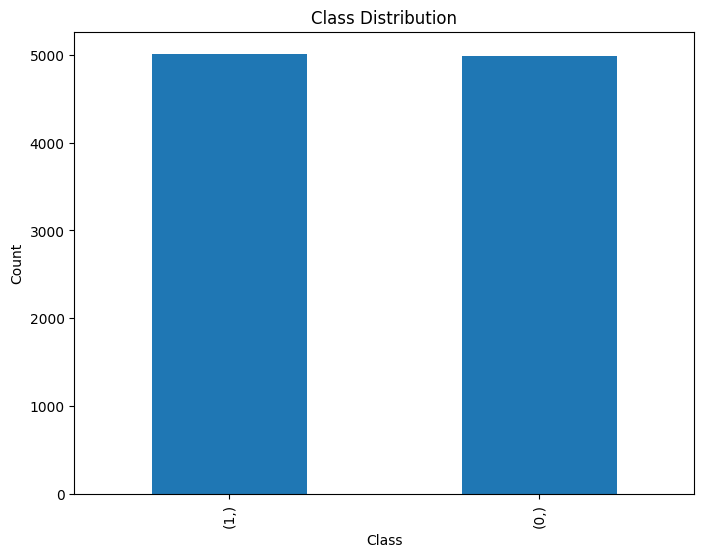

Class Distribution:
Fraud
1        0.5016
0        0.4984
Name: proportion, dtype: float64

Imbalance Ratio (Majority:Minority): 1.01:1


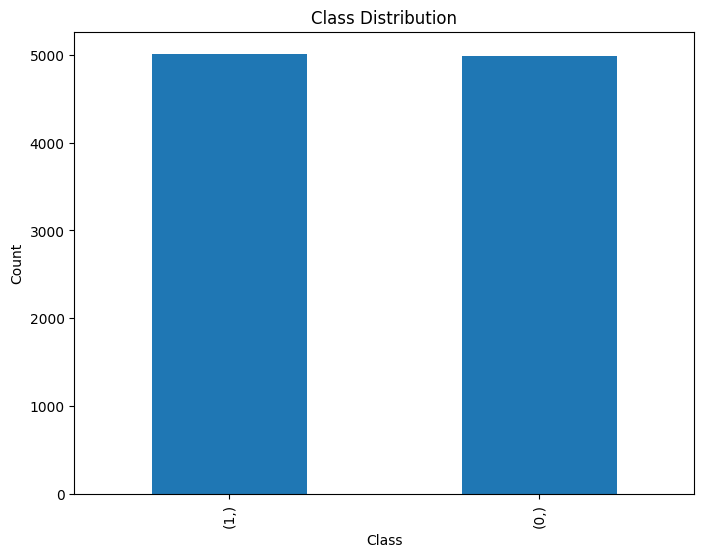

1.0064205457463886 1.0064205457463886


In [172]:
# For any binary classification target
scaled_data_checker = ImbalanceChecker(scaled_data[target])
scaled_data_linear_checker = ImbalanceChecker(scaled_data_linear[target])

scaled_data_imbalance = scaled_data_checker.check_imbalance()
scaled_data_linear_imbalance = scaled_data_linear_checker.check_imbalance()

print(scaled_data_imbalance, scaled_data_linear_imbalance)

In [173]:
class ModelEvaluator:
    def __init__(self, X, y, test_size=0.2, random_state=42):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.split_data()
    
    def split_data(self):
        """Split data into train and test sets"""
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, 
            random_state=self.random_state, stratify=self.y
        )
    
    def handle_imbalance(self, imbalance = 0.5, method='smote', sampling_strategy=1.0):
        if imbalance <= 0.5 or imbalance >= 2:
            """Handle class imbalance"""
            if method == 'smote':
                sampler = SMOTE(sampling_strategy=sampling_strategy, random_state=self.random_state)
            elif method == 'undersample':
                sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=self.random_state)
            
            self.X_train_balanced, self.y_train_balanced = sampler.fit_resample(self.X_train, self.y_train)
            
            print(f"Training set shape after {method}: {self.X_train_balanced.shape}")
            print("Class distribution after balancing:")
            print(pd.Series(self.y_train_balanced).value_counts(normalize=True))
        else:
            self.X_train_balanced, self.y_train_balanced = self.X_train, self.y_train
            
            print(f"Balacing is not required")
            print(pd.Series(self.y_train_balanced).value_counts(normalize=True))
    
    def evaluate_model(self, y_true, y_pred, y_pred_proba=None):
        """Calculate and return evaluation metrics"""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred)
        }
        
        if y_pred_proba is not None:
            metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
        
        return metrics
    
    def plot_confusion_matrix(self, y_true, y_pred, title='Confusion Matrix'):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()



In [174]:
class ModelTrainer:
    def __init__(self, evaluator, model_name, model_params=None):
        self.evaluator = evaluator
        self.model_name = model_name
        self.model_params = model_params or {}
        self.model = self.get_model()
        self.results = {}
    
    def get_model(self):
        """Initialize model based on name"""
        models = {
            'logistic': LogisticRegression,
            'xgboost': xgb.XGBClassifier,
            'knn': KNeighborsClassifier,
            'svm': SVC
        }
        
        if self.model_name not in models:
            raise ValueError(f"Unknown model: {self.model_name}")
        
        return models[self.model_name](**self.model_params)
    
    def train_and_evaluate(self, use_balanced=True):
        """Train and evaluate the model"""
        # Get training data
        X_train = self.evaluator.X_train_balanced if use_balanced else self.evaluator.X_train
        y_train = self.evaluator.y_train_balanced if use_balanced else self.evaluator.y_train
        
        # Train model
        self.model.fit(X_train, y_train)
        
        # Predictions
        y_pred = self.model.predict(self.evaluator.X_test)
        try:
            y_pred_proba = self.model.predict_proba(self.evaluator.X_test)[:, 1]
        except:
            y_pred_proba = None
        
        # Evaluate
        self.results = self.evaluator.evaluate_model(
            self.evaluator.y_test, y_pred, y_pred_proba
        )
        
        # Print results
        print(f"\nResults for {self.model_name}:")
        for metric, value in self.results.items():
            print(f"{metric}: {value:.4f}")
        
        # Plot confusion matrix
        self.evaluator.plot_confusion_matrix(
            self.evaluator.y_test, y_pred, 
            title=f'Confusion Matrix - {self.model_name}'
        )
        
        return self.results



In [175]:
def train_all_models(scaled_data, scaled_data_linear, target_col='Fraud'):
    """Train all models on both datasets"""
    results = {}
    trainers = {}  # To store model trainers
    
    # Prepare datasets
    X_tree = scaled_data.drop(target_col, axis=1)
    X_linear = scaled_data_linear.drop(target_col, axis=1)
    y = scaled_data[target_col].astype('int64')
    
    # Initialize evaluators
    tree_evaluator = ModelEvaluator(X_tree, y)
    linear_evaluator = ModelEvaluator(X_linear, y)
    
    # Handle imbalance for both datasets
    tree_evaluator.handle_imbalance(imbalance = scaled_data_imbalance, method='smote')
    linear_evaluator.handle_imbalance(imbalance = scaled_data_linear_imbalance, method='smote')
    
    # Tree-based models (using scaled_data)
    tree_models = {
        'xgboost': {'n_estimators': 100, 'random_state': 42}
    }
    
    for model_name, params in tree_models.items():
        trainer = ModelTrainer(tree_evaluator, model_name, params)
        results[model_name] = trainer.train_and_evaluate()
        trainers[model_name] = trainer  # Store trainer
    
    # Linear and distance-based models (using scaled_data_linear)
    linear_models = {
        'logistic': {'random_state': 42},
        'knn': {'n_neighbors': 5},
        'svm': {'kernel': 'rbf', 'random_state': 42}
    }
    
    for model_name, params in linear_models.items():
        trainer = ModelTrainer(linear_evaluator, model_name, params)
        results[model_name] = trainer.train_and_evaluate()
        trainers[model_name] = trainer  # Store trainer
    
    # Compare all models
    compare_models(results)
    
    return results, trainers, tree_evaluator, linear_evaluator

def compare_models(results):
    """Compare all models using a bar plot"""
    metrics_df = pd.DataFrame(results).T
    
    plt.figure(figsize=(12, 6))
    metrics_df.plot(kind='bar')
    plt.title('Model Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()
    
    # Print best model for each metric
    print("\nBest Models:")
    for metric in metrics_df.columns:
        best_model = metrics_df[metric].idxmax()
        print(f"{metric}: {best_model} ({metrics_df[metric].max():.4f})")

Balacing is not required
Fraud
1    0.501625
0    0.498375
Name: proportion, dtype: float64
Balacing is not required
Fraud
1    0.501625
0    0.498375
Name: proportion, dtype: float64

Results for xgboost:
accuracy: 0.4935
precision: 0.4951
recall: 0.5035
f1: 0.4993
roc_auc: 0.4794


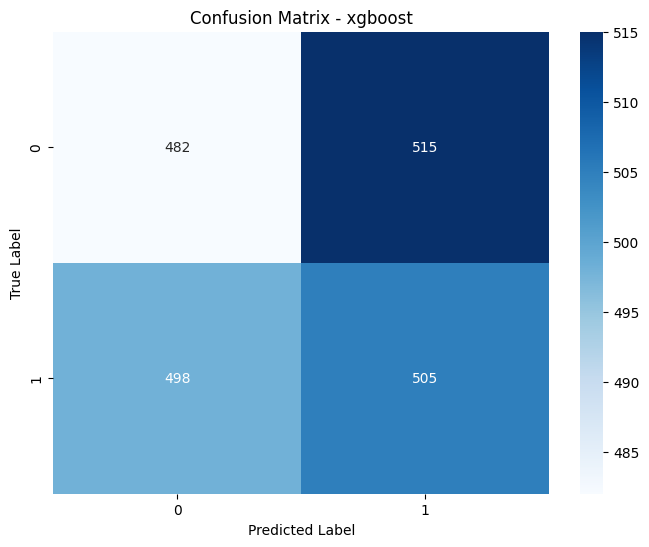


Results for logistic:
accuracy: 0.4985
precision: 0.5000
recall: 0.5384
f1: 0.5185
roc_auc: 0.5086


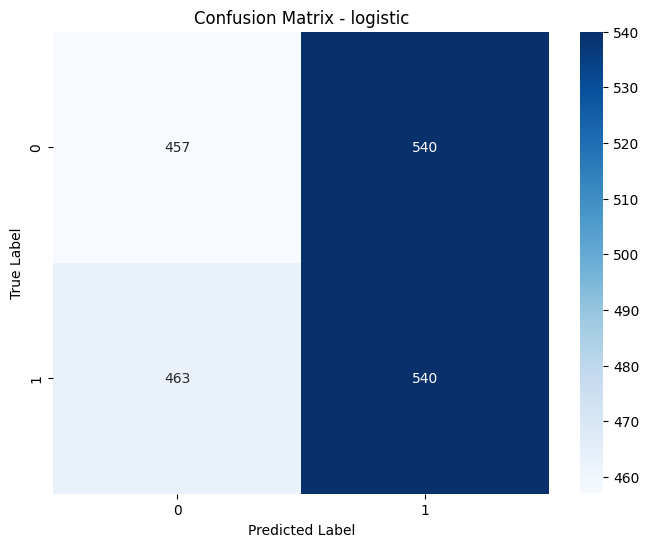


Results for knn:
accuracy: 0.5025
precision: 0.5040
recall: 0.5015
f1: 0.5027
roc_auc: 0.4896


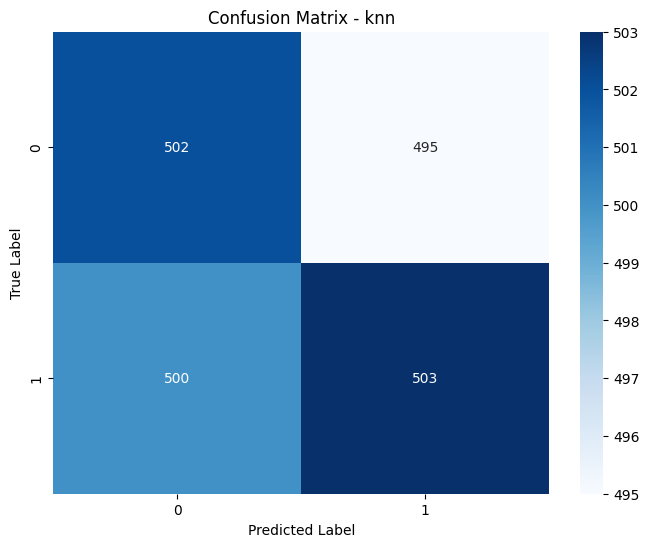


Results for svm:
accuracy: 0.5120
precision: 0.5109
recall: 0.6281
f1: 0.5635


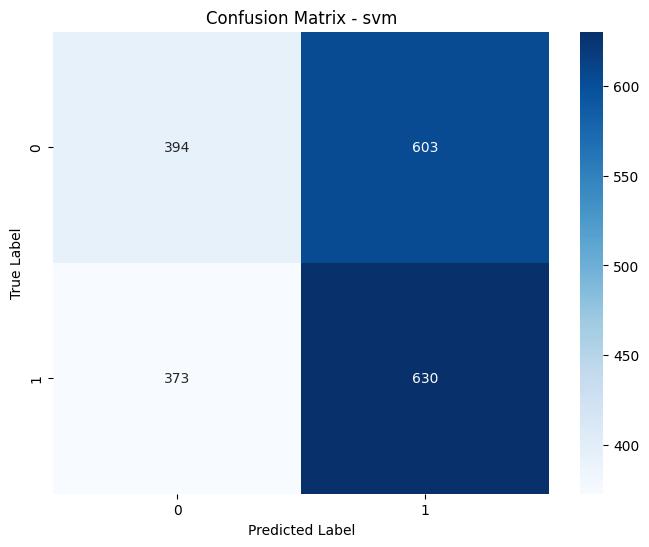

<Figure size 1200x600 with 0 Axes>

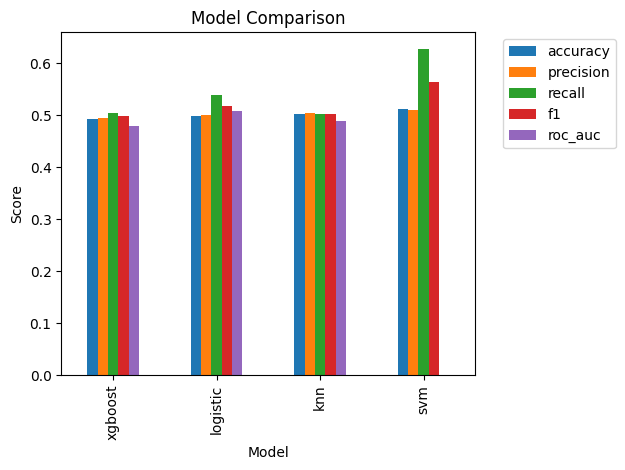


Best Models:
accuracy: svm (0.5120)
precision: svm (0.5109)
recall: svm (0.6281)
f1: svm (0.5635)
roc_auc: logistic (0.5086)


In [176]:
# Training model:
results, trainers, tree_evaluator, linear_evaluator = train_all_models(scaled_data, scaled_data_linear)

In [177]:
# # Collecting trained models
# trained_models = {name: trainer.model for name, trainer in trainers.items()}

# # Save models
# save_trained_models(trained_models)

In [178]:
# # Load models (if needed in a different session)
# models = load_trained_models(['xgboost', 'logistic', 'knn', 'svm'])

# # Evaluate on test set
# test_results = evaluate_models_on_test(models, tree_evaluator, linear_evaluator)

# # Compare train and test performance
# compare_train_test_performance(results, test_results)

Variance check

In [179]:
def evaluate_and_compare_models(trainers, results, tree_evaluator, linear_evaluator):
    """
    Evaluate all trained models on test data and compare with training performance
    """
    test_results = {}
    tree_models = ['xgboost']
    
    # Evaluate each model on test data
    for model_name, trainer in trainers.items():
        print(f"\nEvaluating {model_name} on test set...")
        
        # Select appropriate test data
        if model_name in tree_models:
            X_test = tree_evaluator.X_test
            y_test = tree_evaluator.y_test
        else:
            X_test = linear_evaluator.X_test
            y_test = linear_evaluator.y_test
        
        # Get predictions
        y_pred = trainer.model.predict(X_test)
        try:
            y_pred_proba = trainer.model.predict_proba(X_test)[:, 1]
            has_proba = True
        except:
            y_pred_proba = None
            has_proba = False
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }
        
        if has_proba:
            metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
        
        test_results[model_name] = metrics
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name} (Test Set)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Print metrics
        print(f"\nTest Set Metrics for {model_name}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    # Determine which metrics are available for all models
    available_metrics = set(results[list(results.keys())[0]].keys())
    for model_metrics in results.values():
        available_metrics = available_metrics.intersection(set(model_metrics.keys()))
    
    # Compare train and test performance
    metrics = list(available_metrics)
    models = list(results.keys())
    
    # Create subplot for each metric
    n_metrics = len(metrics)
    n_rows = (n_metrics + 2) // 3  # Ceiling division
    fig, axes = plt.subplots(n_rows, 3, figsize=(20, 6*n_rows))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        
        # Prepare data
        train_scores = []
        test_scores = []
        for model in models:
            train_scores.append(results[model].get(metric, 0))
            test_scores.append(test_results[model].get(metric, 0))
        
        # Set width and positions for bars
        width = 0.35
        x = np.arange(len(models))
        
        # Create bars
        ax.bar(x - width/2, train_scores, width, label='Train')
        ax.bar(x + width/2, test_scores, width, label='Test')
        
        # Customize plot
        ax.set_title(f'{metric.upper()}')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45)
        ax.legend()
        
        # Add value labels
        for i, v in enumerate(train_scores):
            ax.text(i - width/2, v, f'{v:.3f}', ha='center', va='bottom')
        for i, v in enumerate(test_scores):
            ax.text(i + width/2, v, f'{v:.3f}', ha='center', va='bottom')
    
    # Hide empty subplots if any
    for idx in range(len(metrics), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\nDetailed Performance Comparison:")
    print("===============================")
    
    for model in models:
        print(f"\n{model}:")
        print("-" * (len(model) + 1))
        for metric in metrics:
            train_score = results[model].get(metric, None)
            test_score = test_results[model].get(metric, None)
            if train_score is not None and test_score is not None:
                diff = train_score - test_score
                print(f"{metric}:")
                print(f"  Train: {train_score:.4f}")
                print(f"  Test:  {test_score:.4f}")
                print(f"  Diff:  {diff:.4f}")
    
    return test_results


Evaluating xgboost on test set...


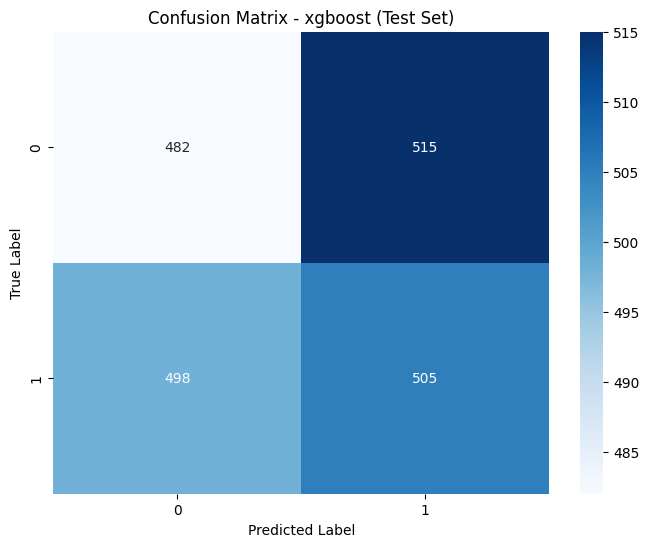


Test Set Metrics for xgboost:
accuracy: 0.4935
precision: 0.4951
recall: 0.5035
f1: 0.4993
roc_auc: 0.4794

Evaluating logistic on test set...


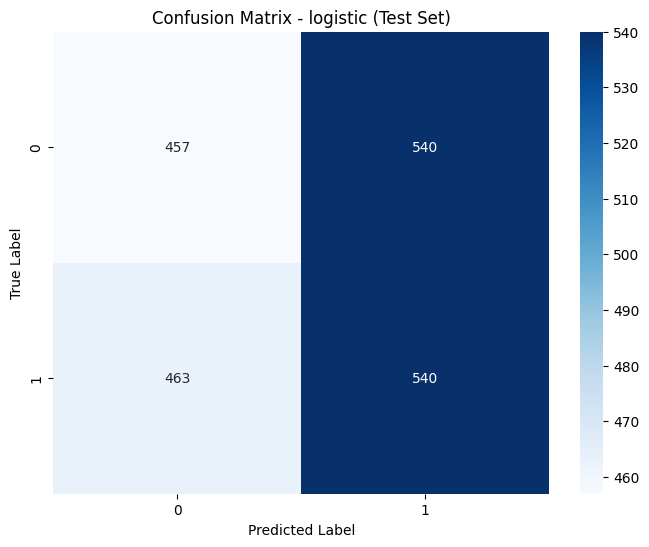


Test Set Metrics for logistic:
accuracy: 0.4985
precision: 0.5000
recall: 0.5384
f1: 0.5185
roc_auc: 0.5086

Evaluating knn on test set...


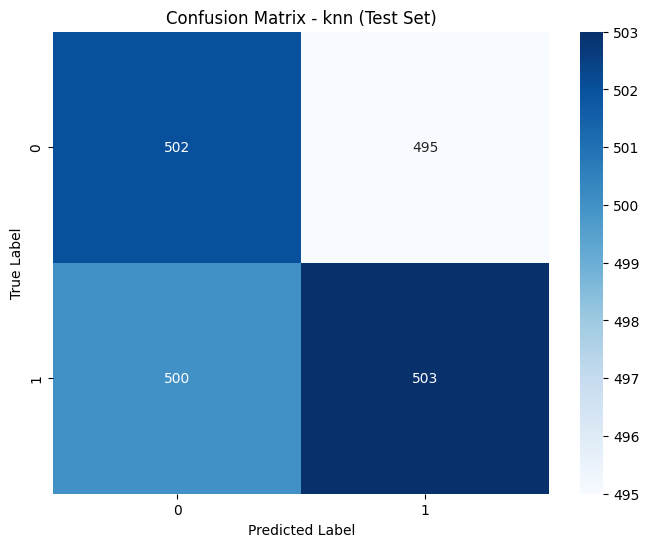


Test Set Metrics for knn:
accuracy: 0.5025
precision: 0.5040
recall: 0.5015
f1: 0.5027
roc_auc: 0.4896

Evaluating svm on test set...


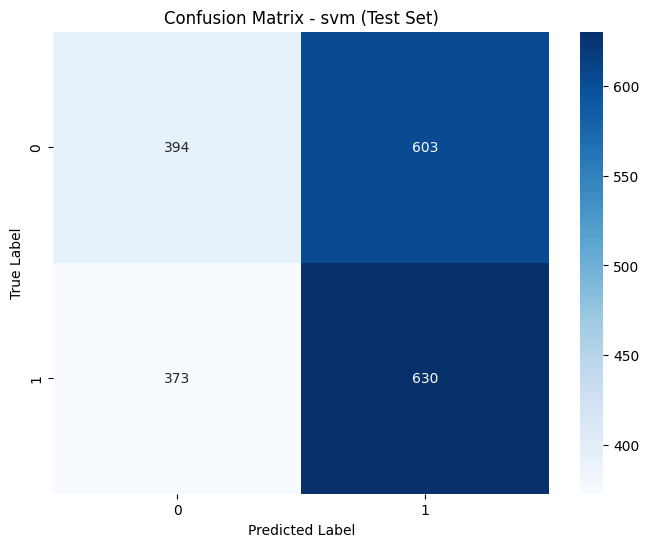


Test Set Metrics for svm:
accuracy: 0.5120
precision: 0.5109
recall: 0.6281
f1: 0.5635


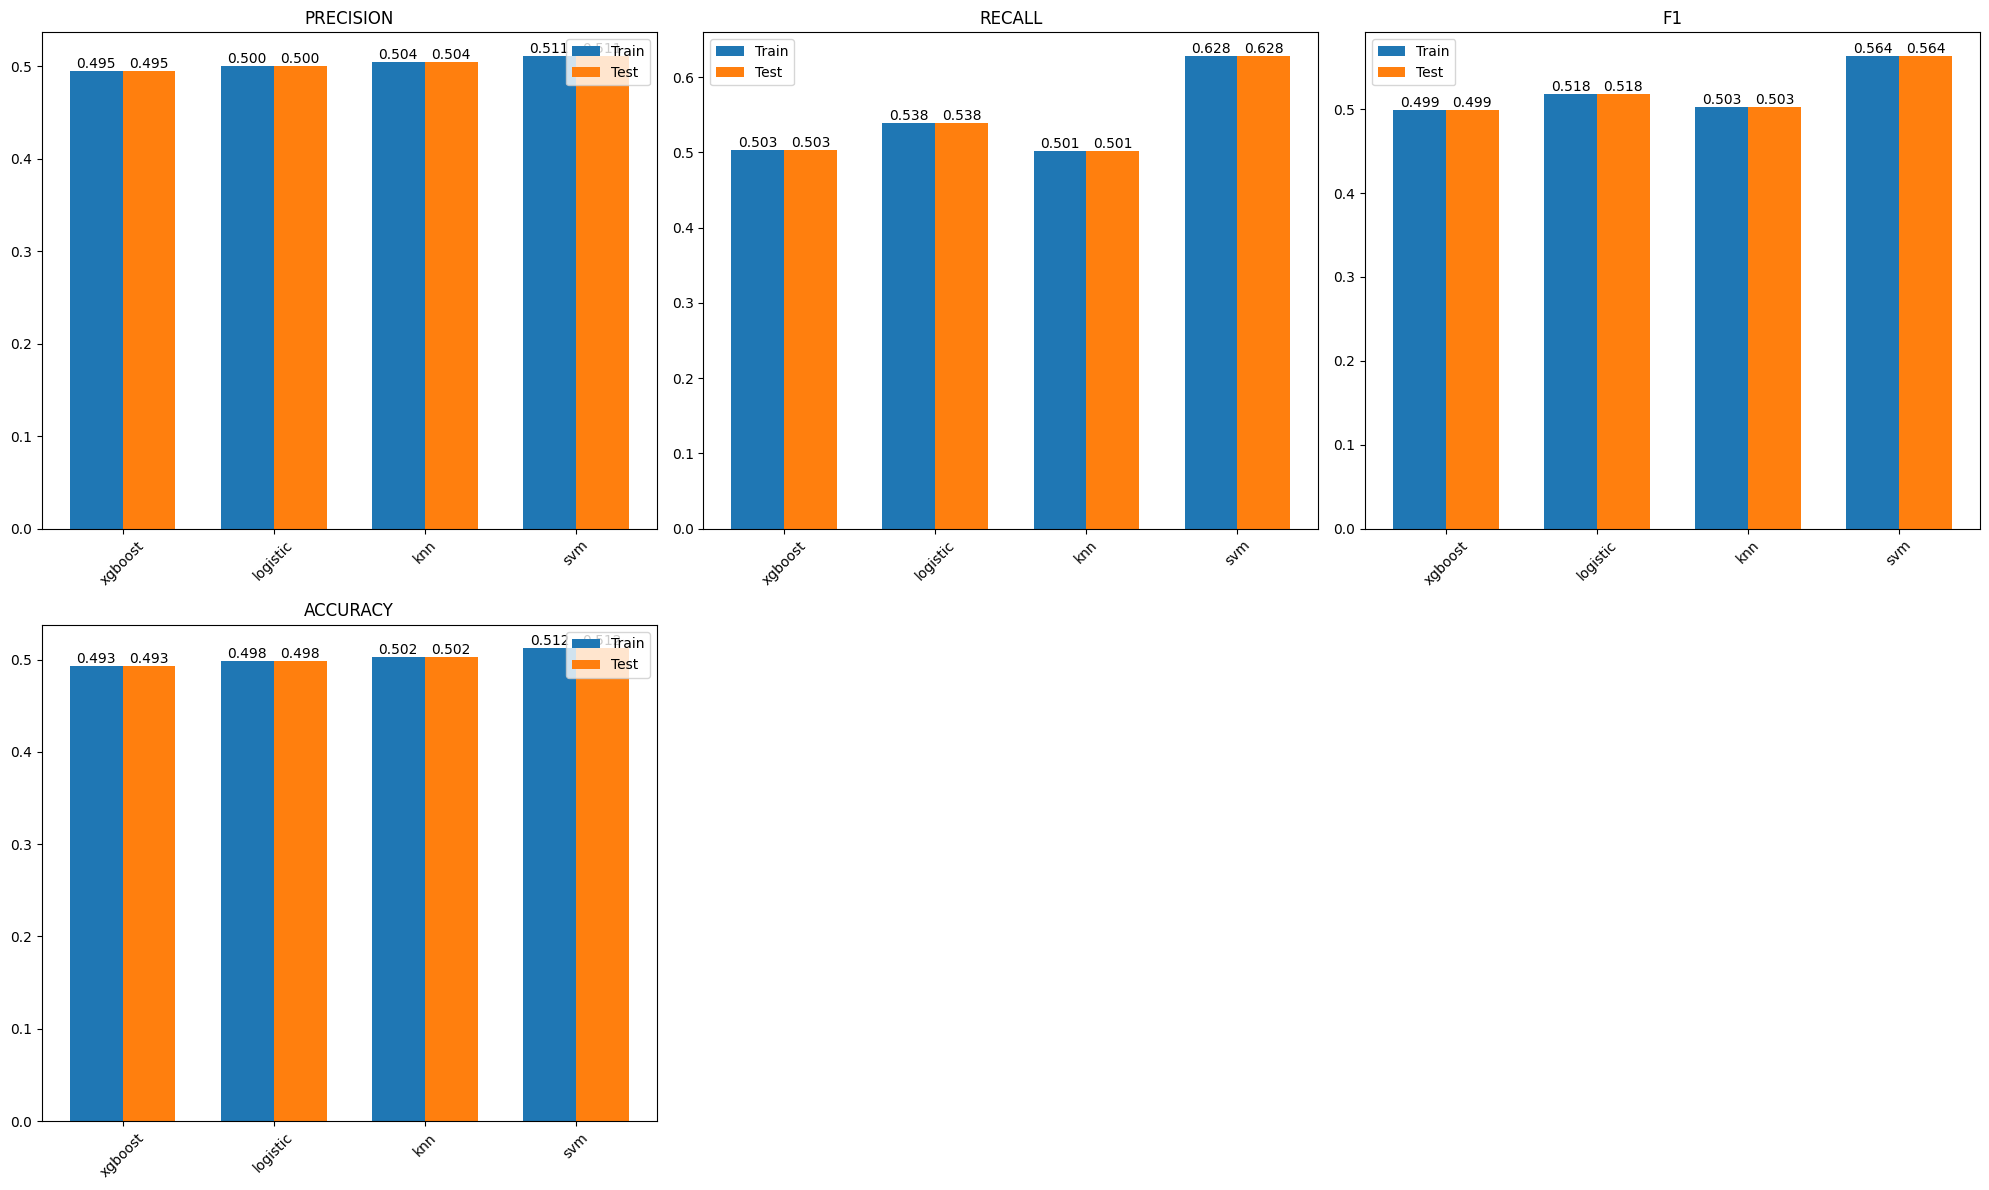


Detailed Performance Comparison:

xgboost:
--------
precision:
  Train: 0.4951
  Test:  0.4951
  Diff:  0.0000
recall:
  Train: 0.5035
  Test:  0.5035
  Diff:  0.0000
f1:
  Train: 0.4993
  Test:  0.4993
  Diff:  0.0000
accuracy:
  Train: 0.4935
  Test:  0.4935
  Diff:  0.0000

logistic:
---------
precision:
  Train: 0.5000
  Test:  0.5000
  Diff:  0.0000
recall:
  Train: 0.5384
  Test:  0.5384
  Diff:  0.0000
f1:
  Train: 0.5185
  Test:  0.5185
  Diff:  0.0000
accuracy:
  Train: 0.4985
  Test:  0.4985
  Diff:  0.0000

knn:
----
precision:
  Train: 0.5040
  Test:  0.5040
  Diff:  0.0000
recall:
  Train: 0.5015
  Test:  0.5015
  Diff:  0.0000
f1:
  Train: 0.5027
  Test:  0.5027
  Diff:  0.0000
accuracy:
  Train: 0.5025
  Test:  0.5025
  Diff:  0.0000

svm:
----
precision:
  Train: 0.5109
  Test:  0.5109
  Diff:  0.0000
recall:
  Train: 0.6281
  Test:  0.6281
  Diff:  0.0000
f1:
  Train: 0.5635
  Test:  0.5635
  Diff:  0.0000
accuracy:
  Train: 0.5120
  Test:  0.5120
  Diff:  0.0000


In [180]:
#Test models on test set
test_results = evaluate_and_compare_models(trainers, results, tree_evaluator, linear_evaluator)
